# FairAnalysis System Project
### Author: Daniel Marley
#### 12/11/22

## Project Overview

The purpose of this project is to provide a generalized package for artificial intelligence developers that provides insight into "historical biases" present in data and provide possible remedies. This form of bias is a human encoded bias that is present in the data, meaning that when an algorithm has a high performing accuracy and meets the ground truth, it may be perpetuating or exacerbating biases. 

A primary goal of the executable is to provide insight on where bias exists in data for a classifier as related to a "sensitive attribute" or legally protected class/status (i.e. gender, race, sexuality, etc). Secondarily, data transforms are performed on the feature space to see if a definition of "fairness" can be achieved in the data. 

The statistical measure for fairness being used is "disparate impact", which defines a system as provenly biased if  groups achieve defined positive outcomes at a rate beneath 80% of a favored group. For disparate impact analysis in this module, data points are clustered by K-Means and then analyzed by these clusterings. The purpose is to fit to a definition of fairness where similar data points across sensitive attibutes achieve positive outcomes at similar rates.

Analysis Consists of 3 parts:
1) Feature Space Analysis
    - The feature space is examined through a correlation matrix between features, the label, and the categorical values of the senstive attribute 
    - Analysis is also performed on the data distribution of the sensitive attrbute and of the label
    
2) Model Output Analysis
    - All models are trained on data sets without the sensitive attribute and the label and through Stratified 10 K-Fold
    - Various models are trained to predict the sensitive attribute, to estimate how much information is left in the dataset relating to the sensitive attribute after its removal
    - Various models are trained to predict the label, locating a model with the highest accuracy
    - The highest achieving model's output can then be analyzed for a defined positive outcome and label for disparate impact analysis overall and by cohort
    
3) Potential Bias Reduction Analysis
    - Bias reduction is attempted through the following tactics, in combination:
        - Incrementally removing strongly correlated features to the sensitive attribute
        - PCA transform (looking to treat sensitive relationships in the data as noise)
        - Class weighted models (to offset potetially imbalanced data)
    - Accuracy, Average Cluster/Cohort Disparate Impact per Sensitive Group, and Average Cluster/Cohort Disparate Impact of All Groups are returned

Ultimately, the transformed feature spaces are written to the '/outputs' folder, for a developer to select by analysis of performance.

## Data in Use

Data for the following model was obtained from ProPublica, in an anlysis it did of the COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) algorithm. The algorithm, which is currently in use, is used by judges to estimate a defendent's likelihood of becoming a recidivist or a repeat offender. ProPublica's analysis - which is linked  in the sources at the end - found that "that black defendants were far more likely than white defendants to be incorrectly judged to be at a higher risk of recidivism, while white defendants were more likely than black defendants to be incorrectly flagged as low risk". 

While lacking access to the data that COMPAS was trained on, ProPublica did make their auditing dataset available, which consisted of more than 10,000 criminal defendants in Broward County, Florida, and compared their recidivism rates over a two-year period. Through data cleaning and selection, this shrunk to a set of 7215 rows with and original 52 features.

I removed exact duplicate features and features related to COMPAS' predictions of recidivism, ultimately arriving with the features: id, first_name, last_name, sex, dob, age, age_cat, race, juvenile_felony_count, juvenile_misdemeanor_count, juvenile_other_count, priors_count, days_b_screening_arrest, case_jail_in_date, case_jail_out_date, case_charge_degree, case_charge_description, and the label is_recid. No preprocessing was performed outside of the module, as it is meant to be generalized.

## Initialization

Imports only require pandas library, logging library, and the fairAnalysis module itself. To initialize an instance of the module, a dataframe must be supplied in addition to the id title, the sensitive attribute title, and the label title. Cluster counts for Disparate Impact analysis default to 10, but I have set it to slightly lower for the example. Data is preprocessed at initialization, with normalization for numerical values, categorical values for string types with less than 10 values, and one-hot encoding for remaining strings.

For our model, race is clearly the sensitive attribute.

In [1]:
import pandas as pd
import logging
from fairAnalysis import FairAnalysis, OutcomeDefinition

df = pd.read_csv('./inputs/nonviolent/two-years-compass-removed-condensed-label.csv')

analyzer = FairAnalysis(df, 
                        id_column='id', 
                        sensitive_column='race', 
                        label_column='is_recid', 
                        cluster_count=8,
                        logging_level=logging.INFO
                    );

INFO:root:Started pre-processing feature analysis data...
INFO:root:Dropping all rows with null values...
INFO:root:314 rows removed.
INFO:root:Categorizing string column data with up to 10 unique values...
INFO:root:One-Hot-Encoding remaining string columns...
INFO:root:Normalizing numeric data...
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
INFO:root:Pre-Processing Complete.
INFO:root:Started pre-processing training data...
INFO:root:Dropping all rows with null values...
INFO:root:314 rows removed.
INFO:root:Categorizing string column data with up to 10 unique values...
INFO:root:One-Hot-Encoding remaining string columns...
INFO:root:Normalizing numeric data...
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` w

## 1. Feature Analysis

In the below feature analysis, it begins with a heatmapped correlation matrix of features against the label and sensitive attribute categories. For our current data, we can see that for the label 'is_recid', 'age' is less correlated while 'priors_count' is strongly correlated. We can also see that priors count is almost as strongly correlated to the "African American" category for race, but not other categories, and the same for age and 'Caucasian'. Other categories also have strongly correlated features that do not seem correlated to the label, such as 'Caucasian' and 'c_charge_degree'. This would imply that there are: 

a) ties in the data between our sensitive attribute, race, and the label

b) relationships in the data that are not related to our label but do relate to the sensitive attribute


In the next section, we then have histograms breaking down the sensitive attribute and the label. The data is imbalanced, with relatively low counts of 'Other', 'Hispanic', 'Asian', and 'Native American' data points. The label space by group is not highly uneven, but 'African American' and 'Native American' are the only two categories with a majority of recidivists. These imbalances are what a user should be aware of in a model's output.

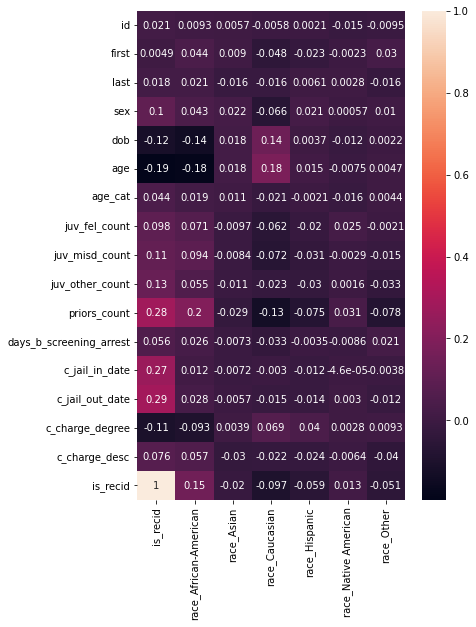

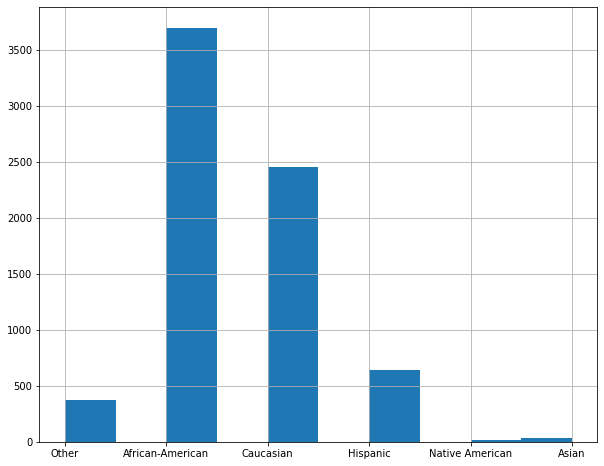

<Figure size 720x576 with 0 Axes>

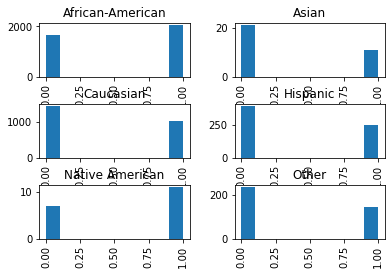

,% is_recid is 0,% is_recid is 1
Group,,
All,0.518852,0.481148
Other,0.620690,0.379310
African-American,0.449134,0.550866
Caucasian,0.582315,0.417685
Hispanic,0.615385,0.384615
Native American,0.388889,0.611111
Asian,0.656250,0.343750


In [2]:
 analyzer.feature_analysis();

## 2.1 Model Output Analysis

After feature analysis is performed, model output analysis can be conducted. First, a subset of classifiers are trained to predict the sensitive attribute. The top performing training accuracy is just under 60%, which is substantially better than random for a 5 class feature space. 

The True Positive Rates (probability that an actual positive will test positive) and True Negative Rates (probability that an actual negatibe will test negative) are also returned for each sensitive group. From this view, it is clear that the model could accurately label 'African American' data points ~80% of the time and could also label data points as not 'Caucasian' ~75% of the time. The remaining categories had poor performance or exceedingly high performances, likely in large part to the low instances of them in the dataset compared to 'African American' and 'Caucasian'.


Next  a subset of classifiers are trained to predict the actual label, and the overall top accuracy performance comes to ~74%. Not high by any standards, but also this is a general model without a high level of specific data tuning.  

In [3]:
%%time
analyzer.train_base_models();

INFO:root:Testing GaussianNB to detect 'race'...
INFO:root:GaussianNB score: 0.11231884057971016
INFO:root:Testing AdaBoostClassifier to detect 'race'...
INFO:root:AdaBoostClassifier score: 0.5336231884057971
INFO:root:Testing RandomForestClassifier to detect 'race'...
INFO:root:RandomForestClassifier score: 0.5982608695652175


,True Positive Rate,True Negative Rate
Group,,
African-American,0.812111,0.499703
Asian,0.000000,0.999854
Caucasian,0.510952,0.778392
Hispanic,0.063356,0.991292
Native American,0.000000,1.000000
Other,0.022222,0.995566


INFO:root:Testing GaussianNB to detect 'is_recid'...
INFO:root:GaussianNB score: 0.558985507246377
INFO:root:Testing AdaBoostClassifier to detect 'is_recid'...
INFO:root:AdaBoostClassifier score: 0.738695652173913
INFO:root:Testing RandomForestClassifier to detect 'is_recid'...
INFO:root:RandomForestClassifier score: 0.7313043478260871


CPU times: user 30.9 s, sys: 65.3 ms, total: 30.9 s
Wall time: 30.9 s


## 2.2.1 Model Output Analysis

With the top model's training performance recorded, we can now conduct disparate impact analysis. All that is required is a "positive outcome" definition. For the immeadiate example below, the positive outcome was defined as the True Positive Rate for 'is_recid'=0, meaning the rate at which non-recidists are properly identified. 

First, we recieve a table showing the TPR (True Positive Rate) by cohort. The purpose of the cohorts is to ensure that we can analyze if like data points are receiving like results. "-" values exist in the table for where the TPR remained undefined (most common in the lower incidence categories). On average, it seems that the TPR values are very similar across the cohorts, with some notable differences in some.

Next are two tables analyzing overall disparate impact and average disparate impact for each racial group compared to each other group. The rows are the "disfavored/minority" groups in the analysis and the columns are the "favored/majority" groups. In this analysis, it is clear that overall African American data points are recieving positive outcomes - properly identified non-recidivists - at ~76% the rate of Caucasian data points. Meanwhile the table also indicates that overall Hispanic data points receive positive outcomes at ~470% the rate of Caucasians - this value and the other wildly high/low values are in part again due to the class imbalance.

The next table, examining the disparate impact for datapoints that are most-similar by cohort, slightly refutes the above, with African American data points being properly identified at a rate of ~89% of Caucasian data points. This is an indication that while our model may not be performing evenly overall, it may not be a cause of bias as like-points are being treated more evenly. 

In [4]:
analyzer.label_model_analysis(OutcomeDefinition.TPR, 0, True);

,Avg. Cohort TPR,Cohort #0 TPR,Cohort #1 TPR,Cohort #2 TPR,Cohort #3 TPR,Cohort #4 TPR,Cohort #5 TPR,Cohort #6 TPR,Cohort #7 TPR
Group,,,,,,,,,
African-American,0.725942,0.647059,0.8125,0.833333,0.583333,0.722222,0.6,0.909091,0.7
Asian,1.000000,-,-,1.000000,-,1.0,-,1.0,1.0
Caucasian,0.870342,1.0,0.846154,1.000000,0.647059,0.666667,0.96,0.892857,0.95
Hispanic,0.958333,1.0,1.0,1.000000,1.0,0.666667,1.0,1.0,1.0
Native American,0.500000,1.0,-,0.000000,1.0,-,0.0,-,-
Other,0.762500,0.5,1.0,1.000000,0.0,0.6,1.0,1.0,1.0


,Maj. African-American,Maj. Asian,Maj. Caucasian,Maj. Hispanic,Maj. Native American,Maj. Other
Index,,,,,,
Min. African-American,1.000000,0.029123,0.558395,0.108215,0.050449,0.101339
Min. Asian,34.337695,1.000000,24.694708,4.909091,-,2.777778
Min. Caucasian,1.790846,0.040495,1.000000,0.193796,0.081979,0.181483
Min. Hispanic,9.240863,0.203704,5.160055,1.000000,0.555556,0.936462
Min. Native American,19.821862,0.000000,12.198304,1.800000,1.0,2.400000
Min. Other,9.867846,0.360000,5.510160,1.067849,0.416667,1.000000


,Maj. African-American,Maj. Asian,Maj. Caucasian,Maj. Hispanic,Maj. Native American,Maj. Other
Index,,,,,,
Min. African-American,1.000000,0.033828,0.661524,0.119004,0.017203,0.091189
Min. Asian,35.320055,1.000000,28.342632,5.250000,-,3.000000
Min. Caucasian,1.839025,0.042460,1.000000,0.204314,0.033294,0.176112
Min. Hispanic,9.710644,0.208929,6.188204,1.000000,0.266667,0.767347
Min. Native American,29.168831,0.000000,16.568182,2.000000,1.0,1.333333
Min. Other,10.157024,0.383333,6.698009,1.281250,0.125,1.000000


## 2.2.2 Model Output Analysis

The following is similar analysis, looking at the TPR for data points where recidivism does occur, meaning recidivists are properly identified. The TPR for each group is not very high, only ~60%. Overall, African American data points achieve ~83% of the positive outcomes of Caucasian data points and when comparing like points, it is almost even with ~98%. Bias is not a current issue in the model when properly identifying recidivists. 

In [5]:
analyzer.label_model_analysis(OutcomeDefinition.TPR, 1, True);

,Avg. Cohort TPR,Cohort #0 TPR,Cohort #1 TPR,Cohort #2 TPR,Cohort #3 TPR,Cohort #4 TPR,Cohort #5 TPR,Cohort #6 TPR,Cohort #7 TPR
Group,,,,,,,,,
African-American,0.706110,0.826087,0.705882,0.6,0.7,0.846154,0.777778,0.526316,0.666667
Asian,1.000000,-,1.000000,-,1.0,1.000000,1.0,-,-
Caucasian,0.528605,0.4375,0.800000,0.363636,0.818182,0.533333,0.4,0.733333,0.142857
Hispanic,0.492857,0.0,0.600000,1.0,0.0,0.750000,0.5,-,0.6
Native American,0.700000,-,1.000000,0.0,-,1.000000,0.5,1.0,-
Other,0.322222,0.0,0.600000,0.0,0.333333,1.000000,-,-,0.0


,Maj. African-American,Maj. Asian,Maj. Caucasian,Maj. Hispanic,Maj. Native American,Maj. Other
Index,,,,,,
Min. African-American,1.000000,0.016538,0.894274,0.211443,0.022788,0.218263
Min. Asian,60.465758,1.000000,38.251781,12.540541,1.200000,7.370690
Min. Caucasian,1.118225,0.026143,1.000000,0.232620,0.030136,0.268512
Min. Hispanic,4.729399,0.079741,4.298850,1.000000,0.190000,1.056366
Min. Native American,43.883383,0.833333,33.182548,5.263158,1.000000,7.500000
Min. Other,4.581619,0.135673,3.724233,0.946642,0.133333,1.000000


,Maj. African-American,Maj. Asian,Maj. Caucasian,Maj. Hispanic,Maj. Native American,Maj. Other
Index,,,,,,
Min. African-American,1.000000,0.018328,1.527639,0.191260,0.028598,0.134874
Min. Asian,64.472403,1.000000,46.055556,11.777778,1.833333,9.555556
Min. Caucasian,1.293748,0.026265,1.000000,0.207344,0.028091,0.310529
Min. Hispanic,4.320015,0.073333,6.682738,1.000000,0.156111,0.483333
Min. Native American,59.550130,1.083333,35.352273,8.250000,1.000000,11.333333
Min. Other,4.498682,0.168148,2.796245,0.805556,0.113333,1.000000


## Potential Bias Reduction Analysis

Finally, we now fit mutliple classifiers on mutliple versions of the data. For this section, a specific majority group must be specified; here it is the "Caucasian" group. The classifiers are a GaussianNB, a AdaBoostClassifier, a RandomForestClassifier, and their class balanced counterparts where applicable. The class balancing is an attempt to resolve any bias from imbalance and potentially improve our model accuracy. The data sets used are the original data set, the data set missing the most strongly correlated features to each racial category, the data set missing the two most strongly correlated features to each racial category, and each previous version of the dataset put. through a PCA transform. The feature drop is to remove unneccessary mappings that exist in the data that imply race and the PCA transform is an attempt to treat race as noise within the data and focus on the label's relationships in the data only. Each version of the data is published to the "outputs/" folder.

In the end, accuracy decreased on every modified dataset. This is an expect tradeoff, as the label and sensitive attribute are somewhat linked in the dataset. Ultimately, in examining the table we can see that we were able to cross the 80% disparate impact threshold for only the RandomForestClassifier where we dropped the most strongly correlated feature per sensitive group in the data. Disparate Impact compared to the majority group acheived 89%, which isn't equal but is certainly an improvement.

In [6]:
%%time
analyzer.test_feature_space_corrections("Caucasian", OutcomeDefinition.TPR, 0)

INFO:root:Fitting GaussianNB:Original...
INFO:root:Fitting GaussianNB:Original:PCA...
INFO:root:Fitting GaussianNB:DropTop1Corr...
INFO:root:Fitting GaussianNB:DropTop1Corr:PCA...
INFO:root:Fitting GaussianNB:DropTop2Corr...
INFO:root:Fitting GaussianNB:DropTop2Corr:PCA...
INFO:root:Fitting AdaBoostClassifier:Original...
INFO:root:Fitting AdaBoostClassifier:Original:PCA...
INFO:root:Fitting AdaBoostClassifier:DropTop1Corr...
INFO:root:Fitting AdaBoostClassifier:DropTop1Corr:PCA...
INFO:root:Fitting AdaBoostClassifier:DropTop2Corr...
INFO:root:Fitting AdaBoostClassifier:DropTop2Corr:PCA...
INFO:root:Fitting AdaBoostClassifierBalanced:Original...
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be re

,GaussianNB:Original,GaussianNB:Original:PCA,GaussianNB:DropTop1Corr,GaussianNB:DropTop1Corr:PCA,GaussianNB:DropTop2Corr,GaussianNB:DropTop2Corr:PCA,AdaBoostClassifier:Original,AdaBoostClassifier:Original:PCA,AdaBoostClassifier:DropTop1Corr,AdaBoostClassifier:DropTop1Corr:PCA,...,RandomForestClassifier:DropTop1Corr,RandomForestClassifier:DropTop1Corr:PCA,RandomForestClassifier:DropTop2Corr,RandomForestClassifier:DropTop2Corr:PCA,RandomForestClassifierBalanced:Original,RandomForestClassifierBalanced:Original:PCA,RandomForestClassifierBalanced:DropTop1Corr,RandomForestClassifierBalanced:DropTop1Corr:PCA,RandomForestClassifierBalanced:DropTop2Corr,RandomForestClassifierBalanced:DropTop2Corr:PCA
Index,,,,,,,,,,,,,,,,,,,,,
Model Accuracy,0.561884,0.566377,0.571014,0.554203,0.566377,0.550000,0.739565,0.699275,0.702754,0.674783,...,0.679855,0.660145,0.644493,0.644348,0.729710,0.698696,0.681159,0.652609,0.651159,0.649565
Average Cohort DI,5.980911,6.550645,8.518508,8.241565,8.363154,8.446791,10.363684,8.225999,7.350553,5.610769,...,9.190740,7.246545,7.319694,9.334371,10.681402,9.626049,9.249923,6.976079,7.974479,9.820022
Average African-American Cohort DI,0.715035,0.596418,0.733276,0.779342,0.757769,0.639277,0.579631,0.902277,0.891608,0.662020,...,0.728339,0.728671,0.768477,0.951051,0.746074,0.615486,0.592423,0.650743,0.708227,0.847371
Average Asian Cohort DI,19.435307,23.098633,35.737610,20.456962,29.111378,24.965049,33.154389,21.595338,30.286972,20.565657,...,37.545042,27.497222,12.642857,11.408832,33.309697,32.616667,28.549683,15.260714,22.776256,22.589174
Average Caucasian Cohort DI,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Average Hispanic Cohort DI,4.280870,4.219244,4.939349,8.223026,4.984885,6.779242,6.361145,4.353855,3.677686,5.466736,...,3.915254,6.436520,5.798260,3.875544,5.544720,5.798929,3.914740,9.546280,4.305718,5.193698
Average Native American Cohort DI,3.960000,4.976190,2.678571,7.512346,5.250000,4.775510,13.000000,13.333333,0.000000,0.000000,...,4.760000,0.000000,17.020000,26.270833,13.385417,11.822222,14.465000,9.262500,9.488095,21.600000
Average Other Cohort DI,6.494256,5.413382,6.022240,11.477714,9.074890,12.521668,8.086937,8.171192,8.247051,5.970202,...,7.195805,7.816855,6.688568,12.499964,10.102504,5.902989,6.977694,6.136235,9.568577,7.689891


CPU times: user 10min 7s, sys: 9.52 s, total: 10min 17s
Wall time: 10min 6s


## Summary

In summary, I am pleased with the work that I was able to complete with this module. The largest risk in my project turned out to be finding biased data. It was very difficult to find any data labeled with sensitive attribute where bias may exist, as in many of these settings (financial, medical, penal) it is either illegal to record sensitive data or that data cannot be released to the public. A large take-away is that for bias to properly be addressed within artifical intelligence, we may need to start require recording this data for the ability to complete analysis; This was a commmon view in my research for this project that I had not considered before.

If I had more time, I would work to further refine the psuedo-auto ML I employed throughout this module in handling the data and training models. For higher accuracy - and potentially further bias analysis - either this would be needed or a more extensive dataset would be. Both would be preferable, given the limitations of disparate impact analysis on low incidence sensitive groups. If I had more resources as well, I would have trained a Neural Network as well. The processing was too intensive and time costly for my current timeline, but a Neural Network as black box system would strongly underscore the importance of this analysis. Additionally, class weighting the backwards propogation would be an additional avenue to test bias reduction.

Overall, I am satisfied however as I both proved the efficacy in the initial steps of demontrating bias in the case of TPR for non-recidivists and showing fairness in the TPR for recidivists. Additionally, the final improvement in the TPR for the Random Forest Classifier with correlated feature dropout did prove a success in reducing bias and crossing the traditional threshold for disparate impact of 80%. 

## Sources

AnalyticsIndiaMagazine: https://analyticsindiamag.com/5-different-ways-to-reduce-noise-in-an-imbalanced-dataset/

Brookings: https://www.brookings.edu/research/algorithmic-bias-detection-and-mitigation-best-practices-and-policies-to-reduce-consumer-harms/

IBM: https://www.ibm.com/docs/en/cloud-paks/cp-data/4.0?topic=overview-disparate-impact

McKinsey: https://www.mckinsey.com/featured-insights/artificial-intelligence/tackling-bias-in-artificial-intelligence-and-in-humans

ProPublica: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
    
https://github.com/propublica/compas-analysis

Sci-Kit Learn: https://scikit-learn.org/stable/index.html
